In [ ]:
PATH_DRIVE = '/content/drive'
PATH_DRIVE_TP = PATH_DRIVE + '/MyDrive/TP_Datos_2C2021/parte_2'
PATH_DRIVE_TP_PREDICCIONES = PATH_DRIVE_TP + '/predicciones'

KNN_IMPUTER_COMPUTAR = False
KNN_IMPUTER_PATH_VALUES = PATH_DRIVE_TP + '/imputaciones/hamburguesas_values_knn.csv'
KNN_IMPUTER_PATH_VAL_DEV = PATH_DRIVE_TP + '/imputaciones/hamburguesas_val_dev_knn.csv'
KNN_IMPUTER_PATH_TEST = PATH_DRIVE_TP + '/imputaciones/hamburguesas_test_knn.csv'

In [ ]:
from google.colab import drive
import sys

drive.mount(PATH_DRIVE, force_remount=True)
sys.path.insert(0, PATH_DRIVE_TP)

Mounted at /content/drive


In [ ]:
!pip install category_encoders

from preprocessing import *

     |████████████████████████████████| 82 kB 402 kB/s 


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

#Librerías de métricas
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

# haciendo los graficos un poco mas bonitos en matplotlib
plt.style.use('default') 
#plt.rcParams['figure.figsize'] = (20, 10)

plt.rcParams['figure.dpi'] = 150

# seteando tipo de grid en seaborn
sns.set_theme(style='ticks', palette=None, font_scale=.9) 

Descargamos los datasets

In [ ]:
VALUES_URL = 'https://docs.google.com/spreadsheets/d/1wduqo5WyYmCpaGnE81sLNGU0VSodIekMfpmEwU0fGqs'
TARGET_URL = 'https://docs.google.com/spreadsheets/d/1gvZ03uAL6THwd04Y98GtIj6SeAHiKyQY5UisuuyFSUs'
TEST_URL = 'https://docs.google.com/spreadsheets/d/1mR_JNN0-ceiB5qV42Ff9hznz0HtWaoPF3B9zNGoNPY8'

hamburguesas_values, hamburguesas_target, hamburguesas_test = descargar_datasets(
    VALUES_URL, 
    TARGET_URL, 
    TEST_URL
  )

In [ ]:
#Split en mi dataset de train y mi dataset de test
X_train, X_test, y_train, y_test = train_test_split(
    hamburguesas_values, 
    hamburguesas_target, 
    test_size=0.4,
    random_state=66, 
    stratify=hamburguesas_target.astype(str)
)

#Split en mi dataset de val_dev y test_holdout
X_val_dev, X_test_holdout, y_val_dev, y_test_holdout = train_test_split(
    X_test, 
    y_test, 
    test_size=0.1,
    random_state=66, 
    stratify=y_test.llovieron_hamburguesas_al_dia_siguiente.astype(str)
)

### Búsqueda de hiperparámetros del Modelo

In [ ]:
def computar_mejores_hiperparametros(model, hiperparametros, X_train, y_train):
  model_cv = GridSearchCV(
      estimator = model,
      param_grid = hiperparametros,
      scoring='roc_auc',
      cv=5, 
      verbose=3
  )

  model_cv.fit(X_train, y_train)

  return model_cv.best_params_

Armo el diccionario de hiperparámetros que vamos a buscar

In [ ]:
max_depth_range = np.arange(10, 25, 2)

hiperparametros_a_buscar = dict(
    max_depth = max_depth_range
)

### Funciones utiles para métricas

In [ ]:
def show_metrics_values(y_true, y_pred):
  valor_metrica = roc_auc_score(y_true, y_pred, average='micro')
  print(f'ROC AUC Score {valor_metrica}')
  
  valor_metrica = accuracy_score(y_true, y_pred)
  print(f'Accuracy Score {valor_metrica}')

  valor_metrica = precision_score(y_true, y_pred)
  print(f'Precision Score {valor_metrica}')

  valor_metrica = recall_score(y_true, y_pred)
  print(f'Recall Score {valor_metrica}')

  valor_metrica = f1_score(y_true, y_pred)
  print(f'F1 Score {valor_metrica}')
  

def plot_confusion_matrix(y_true, y_pred):
  names = sorted(set(y_true))
  cm = confusion_matrix(y_true, y_pred)
  df_cm = pd.DataFrame(cm, names, names)

  plt.figure(dpi=100)
  plt.title("Matriz de confusion")
  sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='g', square=True)
  plt.ylabel("True label")
  plt.xlabel("Predicted label")
  plt.show()


def plot_roc(_fpr, _tpr, x):
  roc_auc = auc(_fpr, _tpr)

  plt.figure(figsize=(12, 6), dpi=100)
  plt.plot(
      _fpr, _tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})'
  )
  plt.scatter(_fpr, x)
  plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver operating characteristic')
  plt.legend(loc="lower right")
  plt.show()

## KnnImputer - Standar Scaler - One Hot Encoding con Hashing Trick

Hago el encoding de mis dataset

In [ ]:
#hamburguesas_train_values_ht = hashing_trick_ecoding(hamburguesas_values_escalado)
#hamburguesas_train_target_enc = y_train.llovieron_hamburguesas_al_dia_siguiente.map({'No': 0, 'Si': 1, np.NaN: 0})

#hamburguesas_val_dev_values_ht = hashing_trick_ecoding(hamburguesas_val_dev_escalado)
#hamburguesas_val_dev_target_enc = y_val_dev.llovieron_hamburguesas_al_dia_siguiente.map({'No': 0, 'Si': 1, np.NaN: 0})

hamburguesas_train_values_ht, hamburguesas_val_dev_values_ht, X_test_holdout_sn = preprocessing_knn_imputer_standar_escaler_one_hot_encoding_hashing_trick(
    X_train, 
    X_val_dev, 
    X_test_holdout
)

In [ ]:
hamburguesas_train_target_enc = y_train.llovieron_hamburguesas_al_dia_siguiente.map({'no': 0, 'si': 1, np.NaN: 0})
hamburguesas_val_dev_target_enc = y_val_dev.llovieron_hamburguesas_al_dia_siguiente.map({'no': 0, 'si': 1, np.NaN: 0})

In [ ]:
hamburguesas_train_target_enc

id
77161     0
32550     0
28412     0
83279     0
29108     0
         ..
1485      0
105240    0
53972     0
26478     0
89570     0
Name: llovieron_hamburguesas_al_dia_siguiente, Length: 69820, dtype: int64

Busco los hiperparametros de mi modelo

In [ ]:
model = RandomForestClassifier()

hiperparametros = computar_mejores_hiperparametros(
    model = model, 
    hiperparametros = hiperparametros_a_buscar, 
    X_train = hamburguesas_train_values_ht, 
    y_train = hamburguesas_train_target_enc
)

hiperparametros

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END ......................max_depth=10;, score=0.853 total time=   6.7s
[CV 2/5] END ......................max_depth=10;, score=0.854 total time=   6.6s
[CV 3/5] END ......................max_depth=10;, score=0.855 total time=   6.7s
[CV 4/5] END ......................max_depth=10;, score=0.857 total time=   6.6s
[CV 5/5] END ......................max_depth=10;, score=0.855 total time=   6.5s
[CV 1/5] END ......................max_depth=12;, score=0.856 total time=   7.9s
[CV 2/5] END ......................max_depth=12;, score=0.858 total time=   8.0s
[CV 3/5] END ......................max_depth=12;, score=0.857 total time=   7.9s
[CV 4/5] END ......................max_depth=12;, score=0.859 total time=   7.8s
[CV 5/5] END ......................max_depth=12;, score=0.858 total time=   7.8s
[CV 1/5] END ......................max_depth=14;, score=0.859 total time=   9.3s
[CV 2/5] END ......................max_depth=14;,

{'max_depth': 20}

In [ ]:
modelo = RandomForestClassifier(**hiperparametros)
modelo.fit(hamburguesas_train_values_ht, hamburguesas_train_target_enc)

RandomForestClassifier(max_depth=20)

Obtengo las predicciones de mi modelo

In [ ]:
predictions = modelo.predict(hamburguesas_val_dev_values_ht)

#### Métricas del modelo

Los valores de las métricas mas usadas son los siguientes:

In [ ]:
show_metrics_values(hamburguesas_val_dev_target_enc, predictions)

ROC AUC Score 0.7064167757728086
Accuracy Score 0.8477072541952116
Precision Score 0.7500449559431757
Recall Score 0.4552996397773169
F1 Score 0.5666349680749897


Veo la curva ROC, sabiendo que AUC es aproximadamente 0.71 segundo lo obtenido líneas arriba

array([0.        , 0.04246609, 1.        ])

array([0.        , 0.45529964, 1.        ])

array([2, 1, 0])

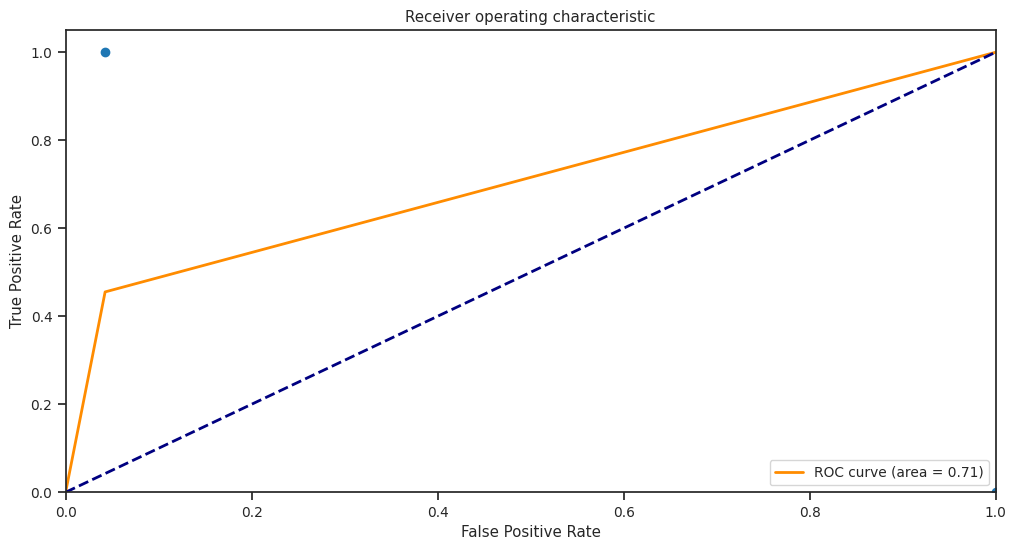

In [ ]:
fpr, tpr, thresholds = roc_curve(hamburguesas_val_dev_target_enc, predictions)

display(fpr)
display(tpr)
display(thresholds)

plot_roc(fpr, tpr, thresholds)

Vemos la matriz de confusión de nuestro modelo

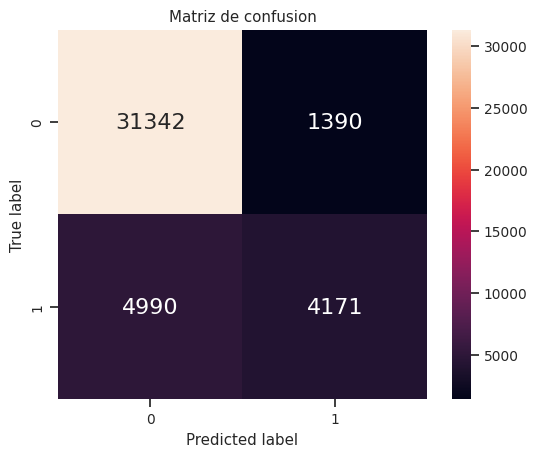

In [ ]:
plot_confusion_matrix(hamburguesas_val_dev_target_enc, predictions)

La matriz de confusion nos muestra nuestros $tp$ (verdaderos positivos, arriba a la izquierda), $fp$ (falsos positivos, abajo a la izquierda), $tn$ (verdaderos negativos, abajo a la derecha) y $fn$ (falsos negativos, arriba a la derecha) en una matriz.

En este caso, la tendencia del modelo es que tiende a predecir 0 sobre 1 porque si vemos la otra diagonal (la de "pifiadas") vemos que hay más casos de era 1 y lo predijo como 0, respecto de era 0 y lo predijo como 1. Por otro lado, la diagonal principal, es "saludable" pero no tanto, pues hay una diferencia muy alta entre los casos en los que era 0 y predijo 0 respecto de los de la otra diagonal pero no sucedió lo mismo en los casos en los que era 1 y predijo 1 (es bastante mayor que en era 0 y predijo 1 pero un poco menor que en era 1 y predijo 0). 

El modelo predijo bien más positivos (36332 casos, 86,73%) que negativos (5561 casos, 13,27%) porque hay una gran cantidad de verdaderos positivos y (en menor medida) falsos positivos, mientras que los verdaderos negativos y falsos negativos hay menos.

Guardamos las predicciones del modelo

In [ ]:
conversion_features_dataset(hamburguesas_test)

hamburguesas_test_sn = knn_imputer(None, None, None, hamburguesas_test, True)
hamburguesas_test_escalado = standar_scaler(hamburguesas_test_sn)
hamburguesas_test_sin_barrio = hashing_trick_encoding(hamburguesas_test_escalado)
hamburguesas_test_ht = one_hot_encoding(hamburguesas_test_sin_barrio)

predicciones = modelo.predict(hamburguesas_test_ht)

In [ ]:
auxiliar = hamburguesas_test.join(hamburguesas_target).reset_index()
auxiliar = auxiliar[['id', 'llovieron_hamburguesas_al_dia_siguiente']]
auxiliar = auxiliar.set_index('id')

nuestra_prediccion = pd.DataFrame(data=predicciones, columns=auxiliar.columns, index=auxiliar.index)

for v in nuestra_prediccion.columns:
  nuestra_prediccion.loc[:, v] = nuestra_prediccion[v].map({0: 'no', 1: 'si',})

nuestra_prediccion.to_csv(PATH_DRIVE_TP_PREDICCIONES + '/random_forest_knn_imputer_standar_scaler_ohe_ht.csv')

## KnnImputer - Standar Scaler - One Hot Encoding con Binary encoding

Hago el encoding de mis dataset

In [ ]:
hamburguesas_train_values_bin, hamburguesas_val_dev_values_bin, X_test_holdout_sn = preprocessing_knn_imputer_standar_escaler_one_hot_encoding_binary_encoding(
    X_train, 
    X_val_dev, 
    X_test_holdout
)

In [ ]:
hamburguesas_train_target_enc = y_train.llovieron_hamburguesas_al_dia_siguiente.map({'no': 0, 'si': 1, np.NaN: 0})
hamburguesas_val_dev_target_enc = y_val_dev.llovieron_hamburguesas_al_dia_siguiente.map({'no': 0, 'si': 1, np.NaN: 0})

Busco los hiperparametros de mi modelo

In [ ]:
model = RandomForestClassifier()

hiperparametros = computar_mejores_hiperparametros(
    model = model, 
    hiperparametros = hiperparametros_a_buscar, 
    X_train = hamburguesas_train_values_bin, 
    y_train = hamburguesas_train_target_enc
)

hiperparametros

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END ......................max_depth=10;, score=0.852 total time=   6.3s
[CV 2/5] END ......................max_depth=10;, score=0.854 total time=   6.3s
[CV 3/5] END ......................max_depth=10;, score=0.854 total time=   6.5s
[CV 4/5] END ......................max_depth=10;, score=0.855 total time=   6.4s
[CV 5/5] END ......................max_depth=10;, score=0.855 total time=   6.4s
[CV 1/5] END ......................max_depth=12;, score=0.855 total time=   7.5s
[CV 2/5] END ......................max_depth=12;, score=0.856 total time=   7.7s
[CV 3/5] END ......................max_depth=12;, score=0.856 total time=   7.7s
[CV 4/5] END ......................max_depth=12;, score=0.858 total time=   7.5s
[CV 5/5] END ......................max_depth=12;, score=0.858 total time=   7.5s
[CV 1/5] END ......................max_depth=14;, score=0.857 total time=   8.6s
[CV 2/5] END ......................max_depth=14;,

{'max_depth': 18}

In [ ]:
hamburguesas_train_values_bin.drop(labels='barrio_4', axis=1, inplace=True)

In [ ]:
modelo = RandomForestClassifier(**hiperparametros)
modelo.fit(hamburguesas_train_values_bin, hamburguesas_train_target_enc)

RandomForestClassifier(max_depth=18)

Obtengo las predicciones de mi modelo

In [ ]:
predictions = modelo.predict(hamburguesas_val_dev_values_bin)

#### Métricas del modelo

Los valores de las métricas mas usadas son los siguientes:

In [ ]:
show_metrics_values(hamburguesas_val_dev_target_enc, predictions)

ROC AUC Score 0.7037116790258339
Accuracy Score 0.8469195330962214
Precision Score 0.7506384531192996
Recall Score 0.4491867700032747
F1 Score 0.5620432971385645


Veo la curva ROC, sabiendo que AUC es aproximadamente 0.71 segundo lo obtenido líneas arriba

array([0.        , 0.04176341, 1.        ])

array([0.        , 0.44918677, 1.        ])

array([2, 1, 0])

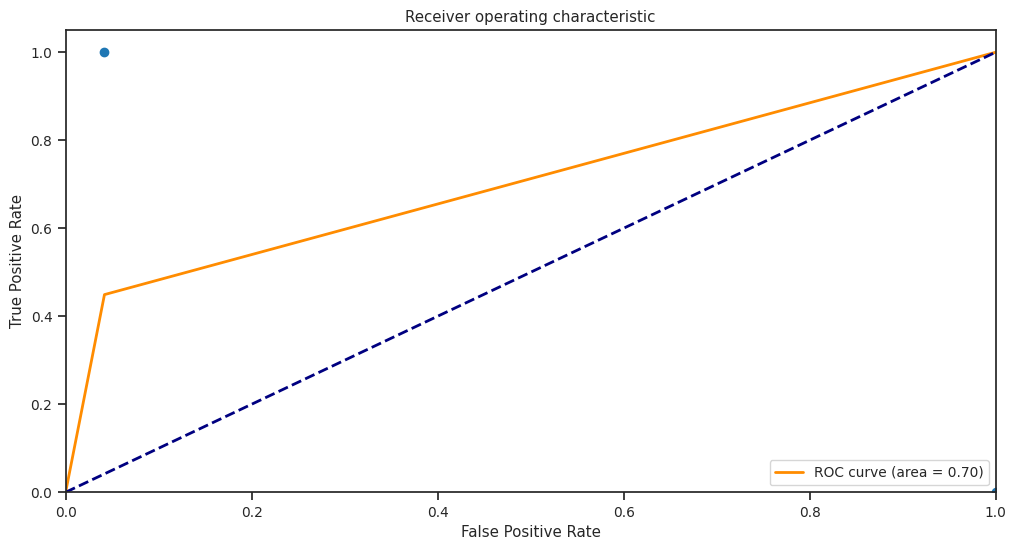

In [ ]:
fpr, tpr, thresholds = roc_curve(hamburguesas_val_dev_target_enc, predictions)

display(fpr)
display(tpr)
display(thresholds)

plot_roc(fpr, tpr, thresholds)

Vemos la matriz de confusión de nuestro modelo

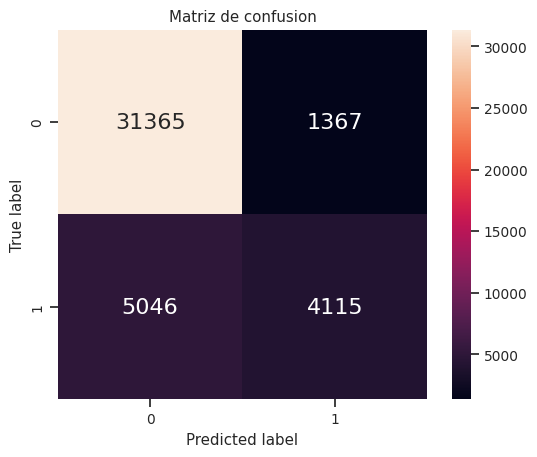

In [ ]:
plot_confusion_matrix(hamburguesas_val_dev_target_enc, predictions)

En este caso, la tendencia del modelo es que tiende a predecir 0 sobre 1 porque si vemos la otra diagonal (la de "pifiadas") vemos que hay más casos de era 1 y lo predijo como 0, respecto de era 0 y lo predijo como 1. Por otro lado, la diagonal principal, es "saludable" pero no tanto, pues hay una diferencia muy alta entre los casos en los que era 0 y predijo 0 respecto de los de la otra diagonal pero no sucedió lo mismo en los casos en los que era 1 y predijo 1 (es bastante mayor que en era 0 y predijo 1 pero un poco menor que en era 1 y predijo 0). 

El modelo predijo bien más positivos (36411 casos, 86,91%) que negativos (5482 casos, 13,09%) porque hay una gran cantidad de verdaderos positivos y (en menor medida) falsos positivos, mientras que los verdaderos negativos y falsos negativos hay menos.

Guardamos las predicciones del modelo

In [ ]:
conversion_features_dataset(hamburguesas_test)

hamburguesas_test_sn = knn_imputer(None, None, None, hamburguesas_test, True)
hamburguesas_test_escalado = standar_scaler(hamburguesas_test_sn)
hamburguesas_test_sin_barrio = binary_encoding(hamburguesas_test_escalado)
hamburguesas_test_bin = one_hot_encoding(hamburguesas_test_sin_barrio)

predicciones = modelo.predict(hamburguesas_test_bin)

In [ ]:
auxiliar = hamburguesas_test.join(hamburguesas_target).reset_index()
auxiliar = auxiliar[['id', 'llovieron_hamburguesas_al_dia_siguiente']]
auxiliar = auxiliar.set_index('id')

nuestra_prediccion = pd.DataFrame(data=predicciones, columns=auxiliar.columns, index=auxiliar.index)

for v in nuestra_prediccion.columns:
  nuestra_prediccion.loc[:, v] = nuestra_prediccion[v].map({0: 'no', 1: 'si',})

nuestra_prediccion.to_csv(PATH_DRIVE_TP_PREDICCIONES + '/random_forest_knn_imputer_standar_scaler_ohe_bin.csv')

## MeanImputer - Robust Scaler - One Hot Encoding con Binary encoding

Hago el encoding de mis dataset

In [ ]:
hamburguesas_train_values_bin, hamburguesas_val_dev_values_bin, X_test_holdout_sn = preprocessing_mean_imputer_robust_escaler_one_hot_encoding_binary_encoding(
    X_train, 
    X_val_dev, 
    X_test_holdout
)

In [ ]:
hamburguesas_train_target_enc = y_train.llovieron_hamburguesas_al_dia_siguiente.map({'no': 0, 'si': 1, np.NaN: 0})
hamburguesas_val_dev_target_enc = y_val_dev.llovieron_hamburguesas_al_dia_siguiente.map({'no': 0, 'si': 1, np.NaN: 0})

Busco los hiperparametros de mi modelo

In [ ]:
model = RandomForestClassifier()

hiperparametros = computar_mejores_hiperparametros(
    model = model, 
    hiperparametros = hiperparametros_a_buscar, 
    X_train = hamburguesas_train_values_bin, 
    y_train = hamburguesas_train_target_enc
)

hiperparametros

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END ......................max_depth=10;, score=0.856 total time=   5.8s
[CV 2/5] END ......................max_depth=10;, score=0.857 total time=   5.8s
[CV 3/5] END ......................max_depth=10;, score=0.856 total time=   5.9s
[CV 4/5] END ......................max_depth=10;, score=0.857 total time=   5.8s
[CV 5/5] END ......................max_depth=10;, score=0.857 total time=   5.8s
[CV 1/5] END ......................max_depth=12;, score=0.859 total time=   6.9s
[CV 2/5] END ......................max_depth=12;, score=0.859 total time=   6.9s
[CV 3/5] END ......................max_depth=12;, score=0.859 total time=   6.9s
[CV 4/5] END ......................max_depth=12;, score=0.860 total time=   6.9s
[CV 5/5] END ......................max_depth=12;, score=0.860 total time=   6.8s
[CV 1/5] END ......................max_depth=14;, score=0.861 total time=   7.9s
[CV 2/5] END ......................max_depth=14;,

{'max_depth': 20}

In [ ]:
hamburguesas_train_values_bin.drop(labels='barrio_4', axis=1, inplace=True)

In [ ]:
modelo = RandomForestClassifier(**hiperparametros)
modelo.fit(hamburguesas_train_values_bin, hamburguesas_train_target_enc)

RandomForestClassifier(max_depth=20)

Obtengo las predicciones de mi modelo

In [ ]:
predictions = modelo.predict(hamburguesas_val_dev_values_bin)

#### Métricas del modelo

Los valores de las métricas mas usadas son los siguientes:

In [ ]:
show_metrics_values(hamburguesas_val_dev_target_enc, predictions)

ROC AUC Score 0.7108090386107347
Accuracy Score 0.8503329911918459
Precision Score 0.7586330291644301
Recall Score 0.46283156860604735
F1 Score 0.5749152542372882


Veo la curva ROC, sabiendo que AUC es aproximadamente 0.71 segundo lo obtenido líneas arriba

array([0.        , 0.04121349, 1.        ])

array([0.        , 0.46283157, 1.        ])

array([2, 1, 0])

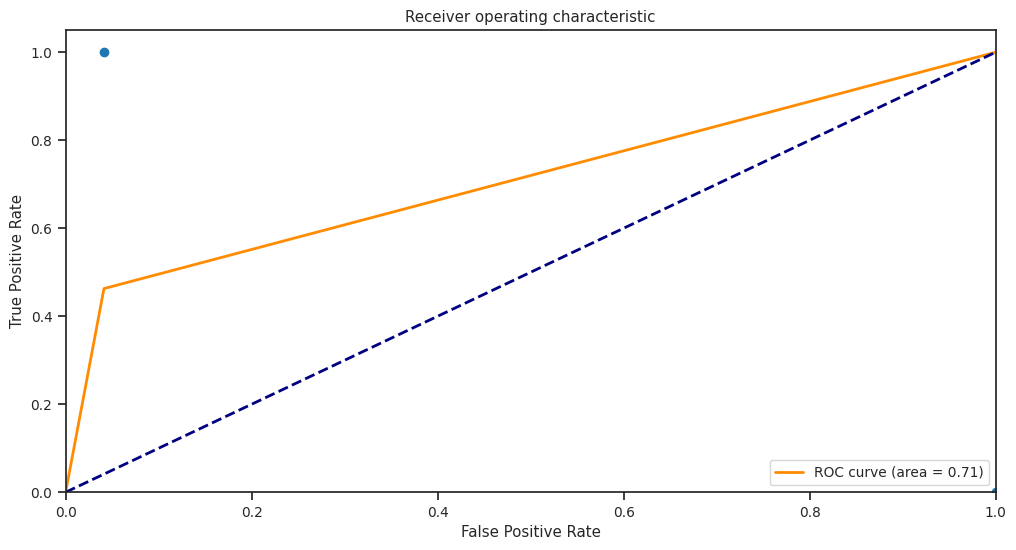

In [ ]:
fpr, tpr, thresholds = roc_curve(hamburguesas_val_dev_target_enc, predictions)

display(fpr)
display(tpr)
display(thresholds)

plot_roc(fpr, tpr, thresholds)

Vemos la matriz de confusión de nuestro modelo

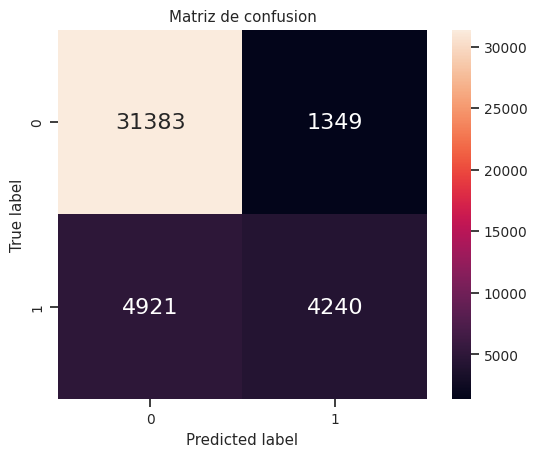

In [ ]:
plot_confusion_matrix(hamburguesas_val_dev_target_enc, predictions)

La matriz de confusion nos muestra nuestros $tp$ (verdaderos positivos), $fp$ (falsos positivos), $tn$ (verdaderos negativos) y $fn$ (falsos negativos) en una matriz. 
La diagonal principal son los valores correctamente clasificados, los otros valores indican la cantidad de puntos mal clasificados.

Guardamos las predicciones del modelo

In [ ]:
conversion_features_dataset(hamburguesas_test)

hamburguesas_test_sn = mean_imputer(None, None, None, hamburguesas_test, True)
hamburguesas_test_escalado = robust_scaler(hamburguesas_test_sn)
hamburguesas_test_sin_barrio = binary_encoding(hamburguesas_test_escalado)
hamburguesas_test_bin = one_hot_encoding(hamburguesas_test_sin_barrio)

predicciones = modelo.predict(hamburguesas_test_bin)

In [ ]:
auxiliar = hamburguesas_test.join(hamburguesas_target).reset_index()
auxiliar = auxiliar[['id', 'llovieron_hamburguesas_al_dia_siguiente']]
auxiliar = auxiliar.set_index('id')

nuestra_prediccion = pd.DataFrame(data=predicciones, columns=auxiliar.columns, index=auxiliar.index)

for v in nuestra_prediccion.columns:
  nuestra_prediccion.loc[:, v] = nuestra_prediccion[v].map({0: 'no', 1: 'si',})

nuestra_prediccion.to_csv(PATH_DRIVE_TP_PREDICCIONES + '/random_forest_mean_imputer_robust_scaler_ohe_ht.csv')